In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Recursos de NLTK
# nltk.download('punkt')
# nltk.download('stopwords')

# nltk.download('wordnet')  # necesario para WordNetLemmatizer


In [4]:
path_file_codebook = r"C:\Users\Celeste\Google Drive Streaming\My Drive\_CODEOP\EDA_Feminism_Influencers_Spain\data\Codebook - Feminism and Anti-feminism.xlsx"

df_codebook = pd.read_excel(path_file_codebook)

df_codebook.head()

,ID,Code,Definition,Survey question / comments,Category,Sub-category,Feminism Stance
0,1,Equating feminism and machismo,"They do not deny discrimination against women,...","""Tan peligroso es el machismo como el feminism...",Antifeminism,Explicit,Strongly opposing feminism
1,2,Denying the necessity of feminism,Emphasizing equality as the real goal and impl...,"""Lo importante no es el feminismo ni el machis...",Antifeminism,Explicit,Moderatedly opposing feminism
2,3,Minimizing gender inequality at the workplace,Skepticism about gender inequality in the work...,"""Las mujeres exageran los problemas que tienen...",Antifeminism,Latent,Opposing feminist issues
3,4,Supporting paternalistic behaviours,Defending the persistence of paternalistic beh...,"""Los hombres deberían proteger a las mujeres """,Antifeminism,Latent,Opposing feminist issues
4,5,Minimizing Sexual Harassment,Accusing women of overreacting to flirting or ...,"""Actualmente las mujeres malinterpretan cualqu...",Antifeminism,Latent,Opposing feminist issues


In [6]:
df_codebook.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          48 non-null     int64 
 1   Code                        48 non-null     object
 2   Definition                  29 non-null     object
 3   Survey question / comments  21 non-null     object
 4   Category                    48 non-null     object
 5   Sub-category                28 non-null     object
 6   Feminism Stance             48 non-null     object
dtypes: int64(1), object(6)
memory usage: 2.8+ KB


In [5]:
df_codebook.shape

(48, 7)

In [7]:
# Convert column names to lowercase and replace characters

df_codebook.columns = df_codebook.columns.str.lower()
df_codebook.columns = df_codebook.columns.str.replace(' / ', '_').str.replace(' ', '_').str.replace('-', '_')

df_codebook.head(2)

,id,code,definition,survey_question_comments,category,sub_category,feminism_stance
0,1,Equating feminism and machismo,"They do not deny discrimination against women,...","""Tan peligroso es el machismo como el feminism...",Antifeminism,Explicit,Strongly opposing feminism
1,2,Denying the necessity of feminism,Emphasizing equality as the real goal and impl...,"""Lo importante no es el feminismo ni el machis...",Antifeminism,Explicit,Moderatedly opposing feminism


In [8]:
df_codebook.describe(exclude='number').T.sort_values(by = 'freq', ascending=False)
                                                
# first line: is unique or is it the first one? 
# 40%, think about that

,count,unique,top,freq
category,48,5,Non-related content,19
sub_category,28,3,Latent,17
feminism_stance,48,12,Content niche,17
code,48,48,Equating feminism and machismo,1
definition,29,29,"They do not deny discrimination against women,...",1
survey_question_comments,21,21,"""Tan peligroso es el machismo como el feminism...",1


In [9]:
#"Content niche" caught my attention: 

df_codebook['feminism_stance'].unique()

array(['Strongly opposing feminism', 'Moderatedly opposing feminism',
       'Opposing feminist issues',
       'Content expressing opinions or behaviors of a sexist or anti feminist nature, but the content does not directly address the feminism-antifeminism debate.\n',
       'Exhibiting traditional gender stereotyping. Content expressing opinions or behaviors of a sexist or anti feminist nature, but the content does not directly address the feminism-antifeminism debate.',
       'Strongly supporting feminism', 'Supporting feminist issues',
       'Suporting feminist issues', 'Content niche',
       'Content characteristics', 'Content format',
       'No content of any type during the week'], dtype=object)

To provide visual insights, I decided to unify the following two labels into one: 'Content expressing opinions or behaviors of a sexist or anti-feminist nature, but the content does not directly address the feminism-antifeminism debate,' and 'Exhibiting traditional gender stereotyping. Content expressing opinions or behaviors of a sexist or anti-feminist nature, but the content does not directly address the feminism-antifeminism debate.' The new label is 'Sexist Content without Debate'

In [99]:
# Crear un nuevo DataFrame con las etiquetas unificadas
visual_df_codebook = df_codebook.copy()  # Hacer una copia del DataFrame original
visual_df_codebook['feminism_stance'] = visual_df_codebook['feminism_stance'].replace({
    'Content expressing opinions or behaviors of a sexist or anti feminist nature, but the content does not directly address the feminism-antifeminism debate.\n':
    'Sexist Content without Debate',
    
    'Exhibiting traditional gender stereotyping. Content expressing opinions or behaviors of a sexist or anti feminist nature, but the content does not directly address the feminism-antifeminism debate.': 
    'Sexist Content without Debate'
})
visual_df_codebook.head()

,id,code,definition,survey_question_comments,category,sub_category,feminism_stance,shortened_feminism_stance,wrapped_feminism_stance
0,1,Equating feminism and machismo,"They do not deny discrimination against women,...","""Tan peligroso es el machismo como el feminism...",Antifeminism,Explicit,Strongly opposing feminism,Strongly opposing feminism,Strongly opposing\nfeminism
1,2,Denying the necessity of feminism,Emphasizing equality as the real goal and impl...,"""Lo importante no es el feminismo ni el machis...",Antifeminism,Explicit,Moderatedly opposing feminism,Moderatedly opposing feminism,Moderatedly opposing\nfeminism
2,3,Minimizing gender inequality at the workplace,Skepticism about gender inequality in the work...,"""Las mujeres exageran los problemas que tienen...",Antifeminism,Latent,Opposing feminist issues,Opposing feminist issues,Opposing feminist issues
3,4,Supporting paternalistic behaviours,Defending the persistence of paternalistic beh...,"""Los hombres deberían proteger a las mujeres """,Antifeminism,Latent,Opposing feminist issues,Opposing feminist issues,Opposing feminist issues
4,5,Minimizing Sexual Harassment,Accusing women of overreacting to flirting or ...,"""Actualmente las mujeres malinterpretan cualqu...",Antifeminism,Latent,Opposing feminist issues,Opposing feminist issues,Opposing feminist issues


C:\Users\Celeste\AppData\Local\Temp\ipykernel_1852\501309833.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(visual_df_codebook,


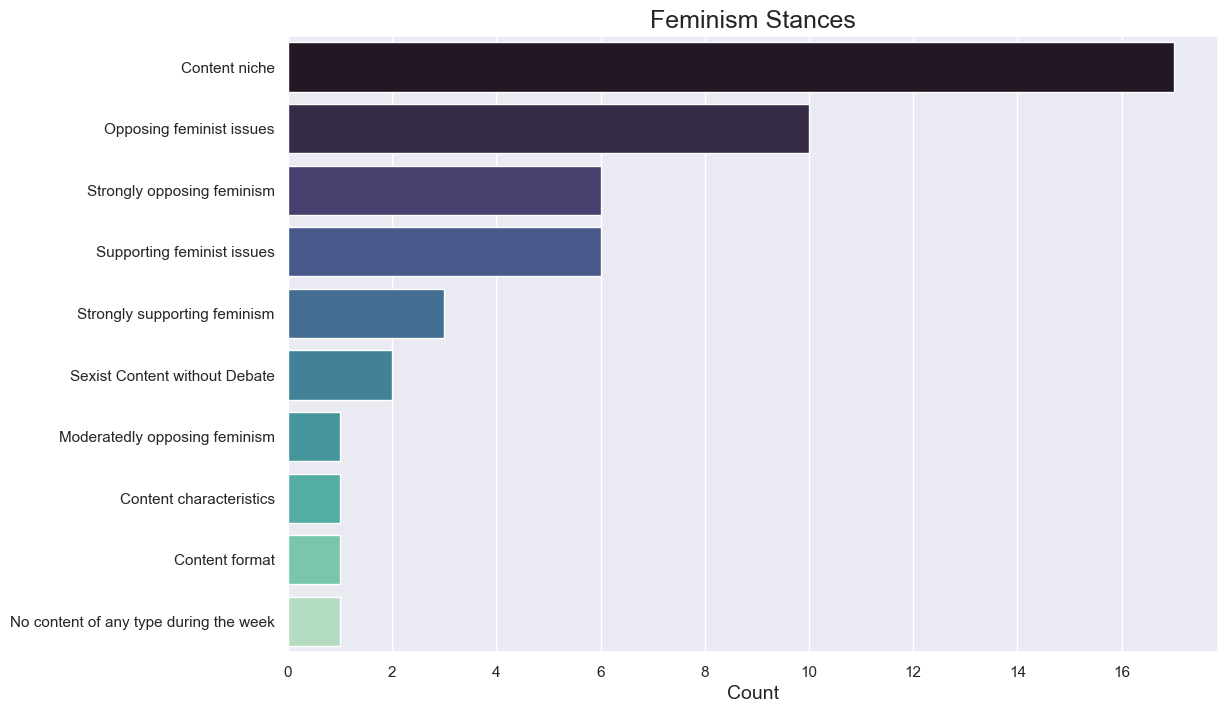

In [107]:
#cool visual 
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid")

sns.countplot(visual_df_codebook,
              y="feminism_stance", 
              order = visual_df_codebook['feminism_stance'].value_counts().index, 
              palette='mako') 

plt.title("Feminism Stances", fontsize=18)
plt.xlabel("Count", fontsize=14)
plt.ylabel("")
plt.show()

EDA and Preprocessing

In [12]:
#eliminar???    FLOW
# #sentiment count = category

df_codebook['category'].notna().value_counts()
df_codebook['category'].value_counts()

#not balanced! 

category
True    48
Name: count, dtype: int64

In [49]:
nan_count = df_codebook['survey_question_comments'].isna().sum()
non_nan_count = df_codebook['survey_question_comments'].notna().sum()

print(f"Valores NaN: {nan_count}")
print(f"Valores no NaN: {non_nan_count}")


Valores NaN: 27
Valores no NaN: 21


In [32]:
# I took this next idea from: 

# https://www.kaggle.com/code/ankumagawa/sentimental-analysis-using-naive-bayes-classifier#3.-SENTIMENTAL-ANALYSIS:

df_codebook['feminism_stance'].unique()

array(['Strongly opposing feminism', 'Moderatedly opposing feminism',
       'Opposing feminist issues',
       'Content expressing opinions or behaviors of a sexist or anti feminist nature, but the content does not directly address the feminism-antifeminism debate.\n',
       'Exhibiting traditional gender stereotyping. Content expressing opinions or behaviors of a sexist or anti feminist nature, but the content does not directly address the feminism-antifeminism debate.',
       'Strongly supporting feminism', 'Supporting feminist issues',
       'Content niche', 'Content characteristics', 'Content format',
       'No content of any type during the week'], dtype=object)

In [25]:
# Unify values in column 'feminism_stance'
df_codebook['feminism_stance'] = df_codebook['feminism_stance'].replace('Suporting feminist issues', 'Supporting feminist issues')

(-0.5, 799.5, 399.5, -0.5)

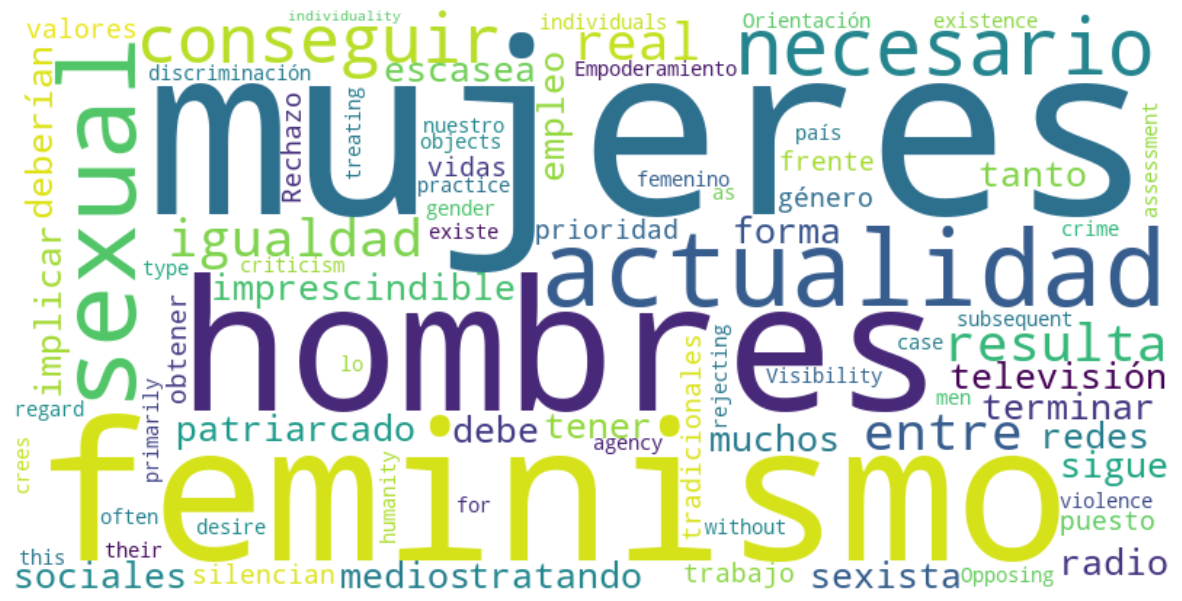

In [68]:
# Define positive stances
positive_stances = ['Strongly supporting feminism', 'Supporting feminist issues']

# Join comments for positive stances
text = " ".join(i for i in df_codebook[df_codebook['feminism_stance'].isin(positive_stances)]['survey_question_comments'])

stopwords = set(['the', 'or', 'by','and','y', 'o', 'que', 'de', 'la', 'el', 'El', 'en', 'a', 'los', 'las', 'por', 'un', 'una', \
                 'con', 'su', 'se', 'del', 'es', 'no', 'para', 'más', 'este', 'esto', 'como','este', 'P22', 'tan',\
                      'donde', 'cuando', 'que', 'quien', 'mi', 'me', 'te', 'su', 'mismo', 'también', 'ser', 'hay', 'of'])

wordcloud = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords).generate(text)

# Plott the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# What are people discussing? Topics with significant impact. Still a reality, still a patriarchy.

(-0.5, 799.5, 399.5, -0.5)

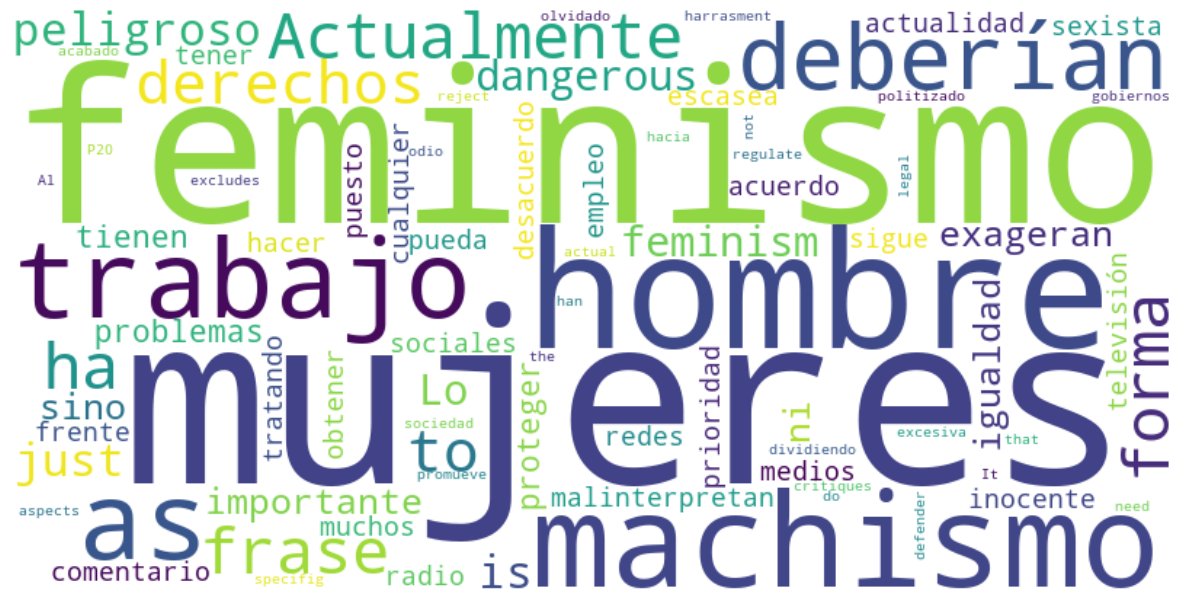

In [57]:
negative_stances = ['Strongly opposing feminism', 'Moderatedly opposing feminism', 'Opposing feminist issues',\
                    'Content expressing opinions or behaviors of a sexist or anti feminist nature, but the content does not directly address the feminism-antifeminism debate.\n',\
                    'Exhibiting traditional gender stereotyping. Content expressing opinions or behaviors of a sexist or anti feminist nature, but the content does not directly address the feminism-antifeminism debate.']

text = " ".join(i for i in df_codebook[df_codebook['feminism_stance'].isin(negative_stances)]['survey_question_comments'] if pd.notna(i))

wordcloud = WordCloud(background_color="white", width=800, height=400, stopwords=stopwords).generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


In [25]:
import spacy
spacy_nlp = spacy.load("en_core_web_sm") 
spacy_nlp = spacy.load("es_core_news_sm")

In [ ]:
# Nan values

df_codebook.isna().sum() 
nan_percentage_def= (19 / 48) * 100
nan_percentage_survey= (27 / 48) * 100
nan_percentage_sub= (20 / 48) * 100

print(f"In the 'definition' column there is a {nan_percentage_def:.2f}% of NaN values, "), 
print(f"in the 'survey_question_comments' column there is a {nan_percentage_survey:.2f}% of NaN values and")
print(f"in the 'sub_category' column there is a {nan_percentage_sub:.2f}% of NaN values")

# Filter the NaN rows in 'Sub-category' column, leaving 'Category'
# why keep 'Category' column?
# provides additional context and help to interpret the meaning of NaN values based on their associated categories.

sub_nan_rows = df_codebook[df_codebook['sub_category'].isna()][['category', 'sub_category']]

sub_nan_rows


# Upon reviewing the filtered results, I notice that every instance where the 'Sub-category' is NaN corresponds to a category that lacks 
# related content to the subject. This implies that the primary category does not have specific content that pertains to the topic we are investigating.

## Reflection -> I need to consider approaching this differently. While this dataset contains limited data, what if I had a larger dataset?
Category column
df_codebook['category'].isna().sum()
df_codebook['category'].value_counts() #not balanced para las metricas
Definition column
df_codebook['definition'].isna().value_counts()
# que hago con esos nans??? son las mismas columnas sin content-related?
# TASK 1: Start with pre-processing text

**Pre-processing**
- Use the tokenization from nltk (word_tokenize)
- Use the 2 regex cleaning rules for your data
- Run lemmatization
- Lower-case
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
def my_clean_data(definition):

    #remove special characters
    definition = re.sub(REPLACE_NO_SPACE, "", definition)
    definition = re.sub(REPLACE_WITH_SPACE, " ", definition)

    #tokenizer
    tokens = word_tokenize(definition)

    # Lower and lemmatize
    lemmatiser = WordNetLemmatizer()

    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]

    return lemmas
# Sanity check

text = df_codebook['definition'][7]

print('before cleaning: ', text)
print('\n')
print('after cleaning: ', my_clean_data(text))
I decided to use CountVectorizer because it's a simpler tool that fits the complexity of the data I'm working with. I think that this method aligns with the fact that my analysis doesn't require a more sophisticated approach.
# vectoriser = CountVectorizer(analyzer= my_clean_data)
# definition_vector = vectoriser.fit_transform(df_codebook.definition)
However, I encountered a problem when trying to apply the function due to the presence of NaN values in the definition column. These values account for almost 40% of my dataset, so removing them would significantly impact the amount of information available for analysis. Therefore, instead of eliminating the rows with NaN, I decided to create a copy of the dataset without these values to apply the relevant functions.
definition_without_nan = df_codebook[df_codebook['definition'].notna()]
vectoriser = CountVectorizer(analyzer= my_clean_data)

definition_vector = vectoriser.fit_transform(definition_without_nan.definition)
definition_vector.shape
definition_vector
Recomendación Final
Comenzar con un análisis de sentimiento y luego contar las top 10 palabras relevantes puede ser un buen enfoque. 